In [ ]:
# 1.1 Install kaggle (only needed if you plan to download dataset from Kaggle)
!pip install --upgrade --quiet kaggle

# 1.2 Create folders
import os
os.makedirs('/content/kaggle', exist_ok=True)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 5.9 MB/s eta 0:00:00


In [ ]:
# Download the dataset (this is the dataset referenced in the paper)
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:58<00:00, 45.5MB/s]
100% 2.29G/2.29G [00:58<00:00, 42.4MB/s]


In [ ]:
!ls -la /content
!ls -la /content/chest_xray
!find /content/chest_xray -maxdepth 2 -type d -print


total 24
drwxr-xr-x 1 root root 4096 Nov 28 16:45 .
drwxr-xr-x 1 root root 4096 Nov 28 16:42 ..
drwxr-xr-x 7 root root 4096 Nov 28 16:45 chest_xray
drwxr-xr-x 4 root root 4096 Nov 20 14:30 .config
drwxr-xr-x 2 root root 4096 Nov 28 16:43 kaggle
drwxr-xr-x 1 root root 4096 Nov 20 14:30 sample_data
total 28
drwxr-xr-x 7 root root 4096 Nov 28 16:45 .
drwxr-xr-x 1 root root 4096 Nov 28 16:45 ..
drwxr-xr-x 5 root root 4096 Nov 28 16:45 chest_xray
drwxr-xr-x 3 root root 4096 Nov 28 16:45 __MACOSX
drwxr-xr-x 4 root root 4096 Nov 28 16:45 test
drwxr-xr-x 4 root root 4096 Nov 28 16:45 train
drwxr-xr-x 4 root root 4096 Nov 28 16:45 val
/content/chest_xray
/content/chest_xray/__MACOSX
/content/chest_xray/__MACOSX/chest_xray
/content/chest_xray/train
/content/chest_xray/train/PNEUMONIA
/content/chest_xray/train/NORMAL
/content/chest_xray/test
/content/chest_xray/test/PNEUMONIA
/content/chest_xray/test/NORMAL
/content/chest_xray/val
/content/chest_xray/val/PNEUMONIA
/content/chest_xray/val/NORMAL
/

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: []


In [ ]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

train_dir = '/content/chest_xray/train'
val_dir   = '/content/chest_xray/val'
test_dir  = '/content/chest_xray/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',   # chest x-rays are grayscale
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
def build_cnn(input_shape=(64,64,1), use_dropout=True):
    model = Sequential()
    # block 1 (matching paper: conv 32, conv 32, maxpool 3x3)
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    if use_dropout:
        model.add(Dropout(0.2))   # paper used dropout 0.2 in feature extractor

    # block 2 (paper: conv 64, conv 128, maxpool 2x2)
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(Conv2D(128, (2,2), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    if use_dropout:
        model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    if use_dropout:
        model.add(Dropout(0.5))   # paper used dropout 0.5 at dense layer
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # binary classification

    return model

# Build model
model = build_cnn(use_dropout=True)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,470,113 (13.24 MB)

 Trainable params: 3,470,113 (13.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lr = 1e-4
model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# callbacks
checkpoint_path = "/content/best_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data = validation_generator,
    validation_steps = max(1, validation_generator.samples // BATCH_SIZE),
    callbacks=[checkpoint, earlystop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.7350 - loss: 0.5959
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/best_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 614ms/step - accuracy: 0.7351 - loss: 0.5957 - val_accuracy: 0.5000 - val_loss: 0.7845
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.7398 - loss: 0.5156
Epoch 2: val_accuracy improved from 0.50000 to 0.62500, saving model to /content/best_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 610ms/step - accuracy: 0.7400 - loss: 0.5152 - val_accuracy: 0.6250 - val_loss: 0.5952
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.8376 - loss: 0.3742
Epoch 3: val_accuracy improved from 0.62500 to 0.68750, saving model to /content/best_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 595ms/step - accuracy: 0.8376 - loss: 0.3742 - val_accuracy: 0.6875 - val_loss: 0.6082
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.8450 - loss: 0.3229
Epoch 4: val_accuracy did not improve from 0.68750
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 594ms/step - accuracy: 0.8450 - loss: 0.3229 - val_accuracy: 0.6250 - val_loss: 0.5695
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.8655 - loss: 0.3068
Epoch 5: val_accuracy did not improve from 0.68750
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 586ms/step - accuracy: 0.8655 - loss: 0.3068 - val_accuracy: 0.6875 - val_loss: 0.5771
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.8642 - loss: 0.3059
Epoch 6: val_accuracy did not improve from 0.68750
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 584ms/step - accuracy: 0.8642 - loss: 0.3059 - val_accuracy: 0.6875 - val_loss: 0.5681
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.8727 - loss: 0.2799
Epoch 7: val_a

163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 586ms/step - accuracy: 0.8727 - loss: 0.2799 - val_accuracy: 0.7500 - val_loss: 0.6469
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.8695 - loss: 0.2879
Epoch 8: val_accuracy did not improve from 0.75000
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 599ms/step - accuracy: 0.8695 - loss: 0.2879 - val_accuracy: 0.7500 - val_loss: 0.6014
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.8749 - loss: 0.2777
Epoch 9: val_accuracy improved from 0.75000 to 0.81250, saving model to /content/best_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 593ms/step - accuracy: 0.8749 - loss: 0.2776 - val_accuracy: 0.8125 - val_loss: 0.7086
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8680 - loss: 0.2888
Epoch 10: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 580ms/step - accuracy: 0.8681 - loss: 0.2887 - val_accuracy: 0.7500 - val_loss: 0.5960
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.8858 - loss: 0.2677
Epoch 11: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 579ms/step - accuracy: 0.8858 - loss: 0.2677 - val_accuracy: 0.6250 - val_loss: 0.5701
Epoch 12/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.8858 - loss: 0.2603
Epoch 12: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 587ms/step - accuracy: 0.8858 - loss: 0.2603 - val_accuracy: 0.6875 - val_loss: 0.7970
Epoch 13/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.8839 - loss: 0.2639
Epoch 13

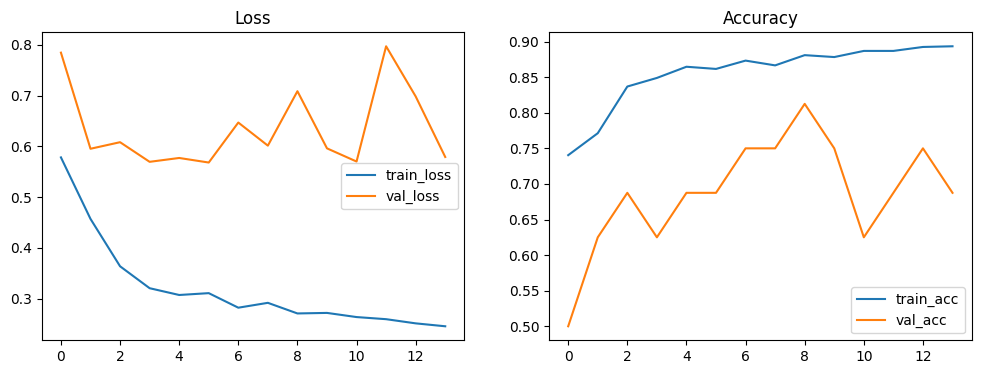

In [ ]:
import matplotlib.pyplot as plt

def plot_history(h):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1,2,2)
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

plot_history(history)


In [ ]:
# load best model
model.load_weights(checkpoint_path)

test_loss, test_acc = model.evaluate(test_generator, steps = max(1, test_generator.samples // BATCH_SIZE))
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 303ms/step - accuracy: 0.8371 - loss: 0.4173
Test accuracy: 0.8438, Test loss: 0.3540


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# predict
y_pred_prob = model.predict(test_generator, steps = int(np.ceil(test_generator.samples / BATCH_SIZE)))
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes  # the ground truth labels (0/1)
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 483ms/step
[[190  44]
 [ 54 336]]
              precision    recall  f1-score   support

      NORMAL       0.78      0.81      0.79       234
   PNEUMONIA       0.88      0.86      0.87       390

    accuracy                           0.84       624
   macro avg       0.83      0.84      0.83       624
weighted avg       0.84      0.84      0.84       624



In [ ]:
# Save model architecture + weights
model.save('/content/pneumonia_cnn_model.h5')


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('/content/pneumonia_cnn_model.h5')
loaded_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,470,115 (13.24 MB)

 Trainable params: 3,470,113 (13.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step


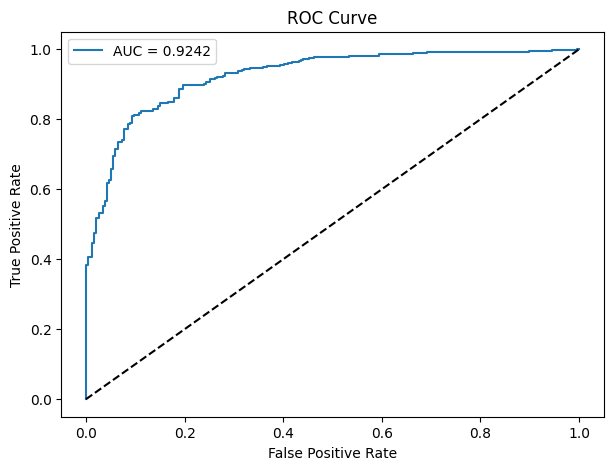

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = loaded_model.predict(test_generator, steps=int(np.ceil(test_generator.samples / BATCH_SIZE)))
y_true = test_generator.classes

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


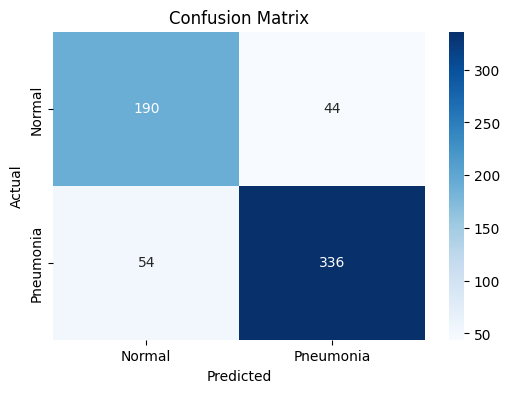

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, (y_pred_prob > 0.5).astype(int))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
